In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os  # For saving/loading models

In [10]:

# --- 1. Simulate Data (Modified for Varied Simulations) ---
def simulate_degrading_signal_varied(sampling_rate=20000, duration=10, window_size_sim=1.024):
    """
    Simulates vibration data over time with increasing defect characteristics
    leading to failure at the end, with added randomness in parameters.
    """
    total_windows = int(duration / window_size_sim)
    samples_per_window_sim = int(sampling_rate * window_size_sim)
    full_signal = []
    timestamps = []

    # Randomize degradation parameters for each simulation run
    base_defect_amplitude = np.random.uniform(0.005, 0.015)
    final_defect_amplitude = np.random.uniform(0.08, 0.15)
    defect_frequency = np.random.uniform(1150, 1250)

    initial_impulses = np.random.randint(1, 4)
    max_impulses_increase = np.random.randint(8, 15)

    for i in range(total_windows):
        t = np.linspace(0, window_size_sim, samples_per_window_sim)

        base = 0.1 * np.sin(2 * np.pi * 50 * t)
        defect_strength = base_defect_amplitude + (i / total_windows) * (final_defect_amplitude - base_defect_amplitude)
        defect = defect_strength * np.sin(2 * np.pi * defect_frequency * t)
        impulses = np.zeros_like(t)
        num_impulses = initial_impulses + int((i / total_windows) * max_impulses_increase)
        impulse_indices = np.random.choice(samples_per_window_sim, size=num_impulses, replace=False)
        impulses[impulse_indices] = np.random.uniform(-1.0, 1.0, size=num_impulses)

        signal = base + defect + impulses
        full_signal.append(signal)
        timestamps.extend([i * window_size_sim + x for x in t])

    full_signal = np.concatenate(full_signal)
    timestamps = np.array(timestamps)
    return timestamps, full_signal, duration


In [11]:

# --- Generate Multiple Instances and Create a List of DataFrames ---
num_simulations = 15  # Increased number of simulations for better split
list_of_degrading_dfs = []

print(f"Generating {num_simulations} simulated data instances...")
for i in range(num_simulations):
    timestamps_i, degrading_signal_i, total_duration_i = simulate_degrading_signal_varied(duration=10 + i * 0.5)
    rul_i = total_duration_i - timestamps_i

    df_i = pd.DataFrame({
        'simulation_id': i,
        'time_sec': timestamps_i,
        'amplitude': degrading_signal_i,
        'RUL_sec': rul_i
    })
    list_of_degrading_dfs.append(df_i)

print(f"\nGenerated {len(list_of_degrading_dfs)} individual DataFrames.")



Generating 15 simulated data instances...

Generated 15 individual DataFrames.


In [24]:
len(list_of_degrading_dfs)

15

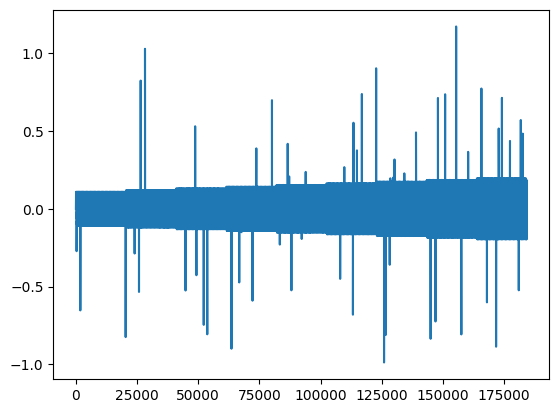

0


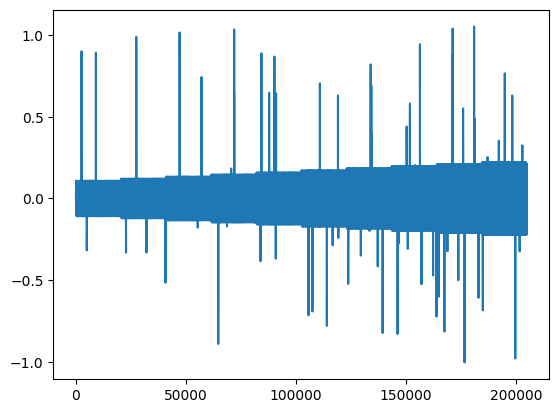

1


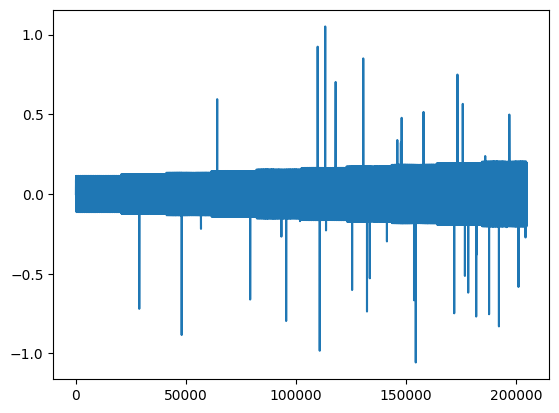

2


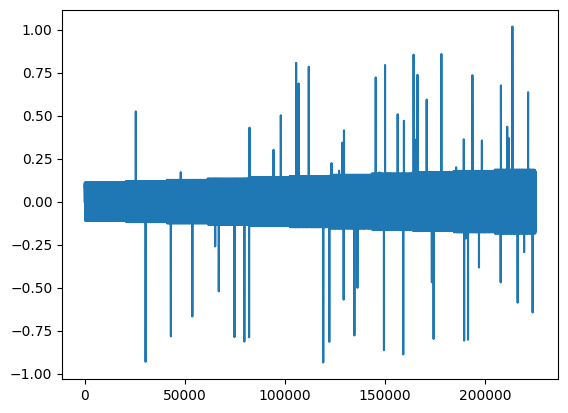

3


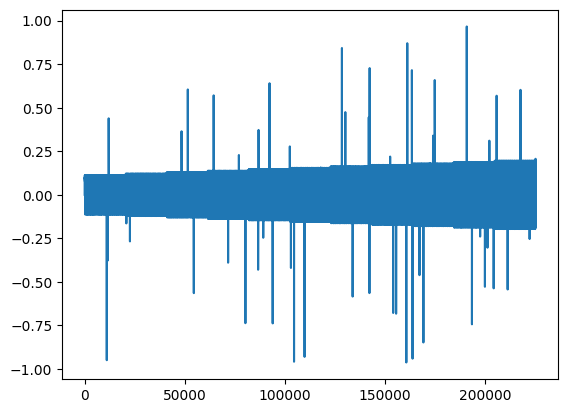

4


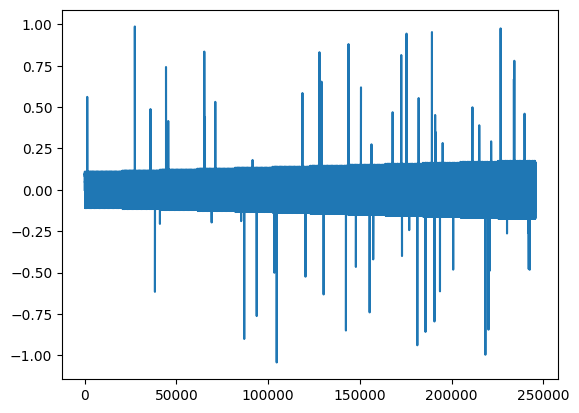

5


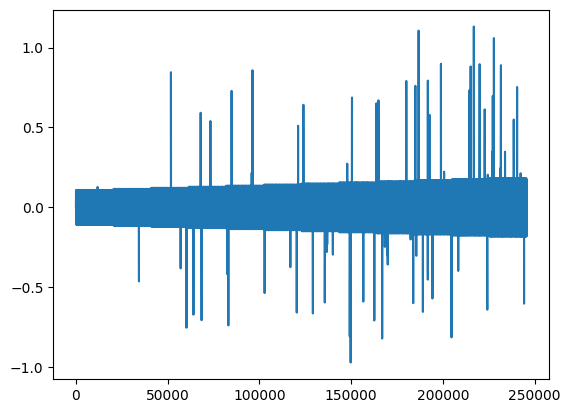

6


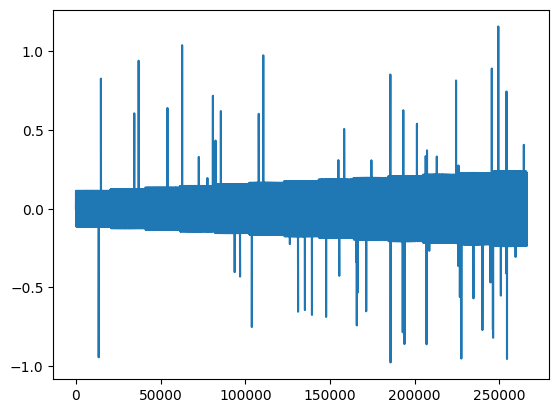

7


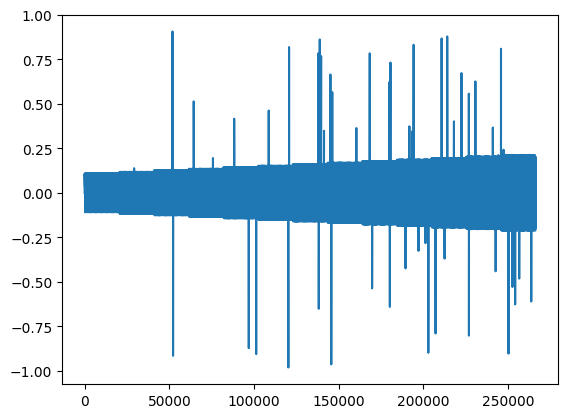

8


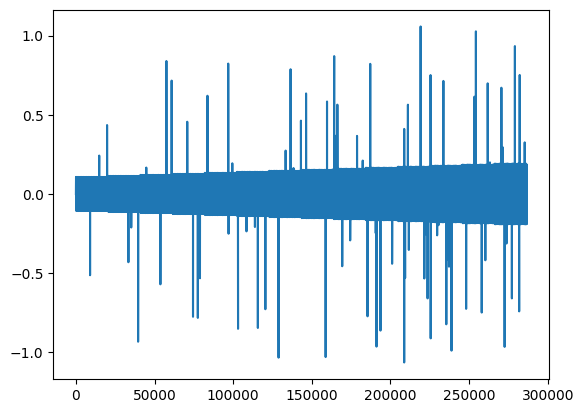

9


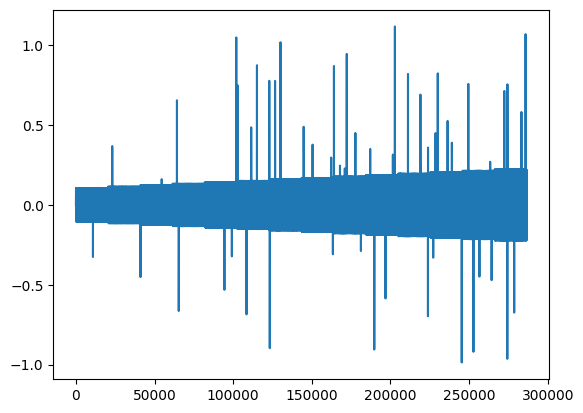

10


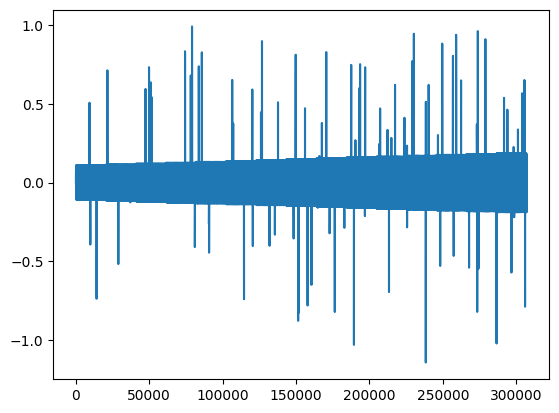

11


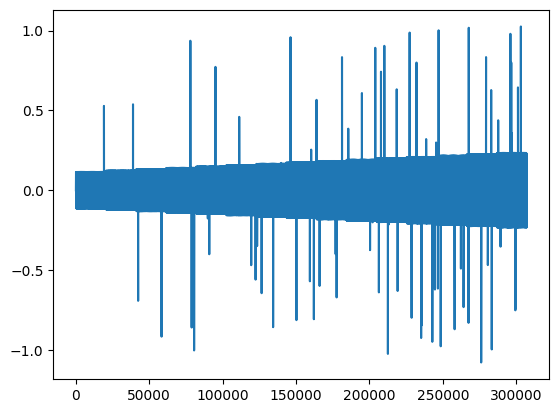

12


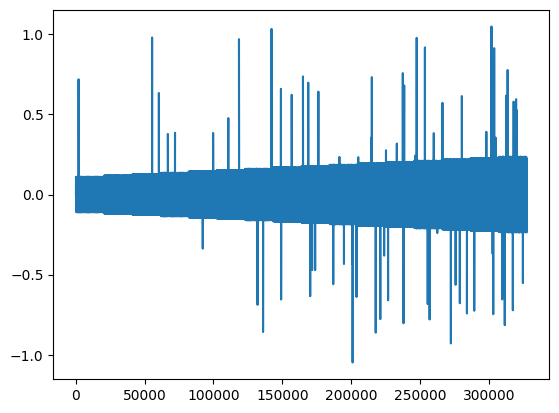

13


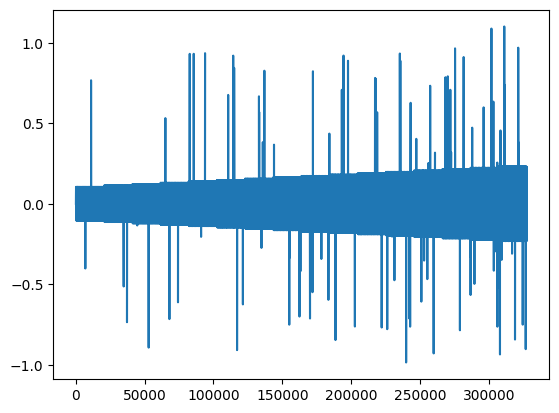

14


In [25]:
for idx, df_i in enumerate(list_of_degrading_dfs):
    df_i.amplitude.plot()
    plt.show()
    print(idx)

In [12]:
# --- 2. PyTorch Data Preparation (Dataset with timestamp) ---

WINDOW_SIZE_SAMPLES = 2048
STEP_SIZE_SAMPLES = 200
class VibrationDataset(Dataset):
    def __init__(self, data_df, window_size, step_size):
        self.data_df = data_df
        self.window_size = window_size
        self.step_size = step_size
        self.inputs = []
        self.targets = []
        self.window_end_times = []

        num_samples = len(data_df)
        for i in range(0, num_samples - window_size + 1, step_size):
            window_end_idx = i + window_size
            input_window = torch.tensor(self.data_df['amplitude'].iloc[i:window_end_idx].values, dtype=torch.float32)
            self.inputs.append(input_window)

            target_rul = torch.tensor(self.data_df['RUL_sec'].iloc[window_end_idx - 1], dtype=torch.float32)
            self.targets.append(target_rul)

            window_end_time = self.data_df['time_sec'].iloc[window_end_idx - 1]
            self.window_end_times.append(window_end_time)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx], self.window_end_times[idx]



In [13]:

# --- Create Datasets and DataLoaders for Training, Validation, and Testing ---

# Split simulations:
# 0-9 for training
# 10-12 for validation (used for early stopping)
# 13-14 for final testing (unseen by training and validation)
train_sim_ids = list(range(10))
val_sim_ids = list(range(10, 13))
test_sim_ids = list(range(13, 15))

# Training DataLoaders
train_datasets = []
for sim_id in train_sim_ids:
    df_sim = list_of_degrading_dfs[sim_id]
    train_datasets.append(VibrationDataset(df_sim, window_size=WINDOW_SIZE_SAMPLES, step_size=STEP_SIZE_SAMPLES))
train_dataset_combined = torch.utils.data.ConcatDataset(train_datasets)
train_dataloader = DataLoader(train_dataset_combined, batch_size=64, shuffle=True)

# Validation DataLoaders
val_datasets = []
for sim_id in val_sim_ids:
    df_sim = list_of_degrading_dfs[sim_id]
    val_datasets.append(VibrationDataset(df_sim, window_size=WINDOW_SIZE_SAMPLES, step_size=STEP_SIZE_SAMPLES))
val_dataset_combined = torch.utils.data.ConcatDataset(val_datasets)
val_dataloader = DataLoader(val_dataset_combined, batch_size=64, shuffle=False)  # No shuffle for validation

# Test DataLoaders (prepared similarly to validation for individual evaluation later)
test_datasets = []
for sim_id in test_sim_ids:
    df_sim = list_of_degrading_dfs[sim_id]
    test_datasets.append(VibrationDataset(df_sim, window_size=WINDOW_SIZE_SAMPLES, step_size=STEP_SIZE_SAMPLES))

print(f"\nTraining on {len(train_sim_ids)} simulations. Total training windows: {len(train_dataset_combined)}")
print(f"Validation on {len(val_sim_ids)} simulations. Total validation windows: {len(val_dataset_combined)}")
print(f"Testing on {len(test_sim_ids)} simulations.")





Training on 10 simulations. Total training windows: 11678
Validation on 3 simulations. Total validation windows: 4476
Testing on 2 simulations.


In [14]:
# --- 3. PyTorch Model Definition (LSTM Example) ---
class RULPredictorLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RULPredictorLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.unsqueeze(2)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


INPUT_SIZE = 1
HIDDEN_SIZE = 128
NUM_LAYERS = 2
OUTPUT_SIZE = 1

model = RULPredictorLSTM(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE)
print(f"\nModel Architecture:\n{model}")




Model Architecture:
RULPredictorLSTM(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


In [15]:

# --- 4. Loss Function and Optimizer ---
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# --- Device Setup (for Mac M3) ---
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon GPU) for acceleration.")
elif torch.cuda.is_available():  # Fallback for other systems
    device = torch.device("cuda")
    print("Using CUDA (NVIDIA GPU) for acceleration.")
else:
    device = torch.device("cpu")
    print("Using CPU for training.")

model.to(device)

# --- 5. Training Loop with Early Stopping ---
NUM_EPOCHS = 100  # Set a higher max epochs, early stopping will stop it
PATIENCE = 10  # Number of epochs to wait for improvement
MIN_DELTA = 0.001  # Minimum change to qualify as an improvement

best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False

training_losses = []
validation_losses = []

# Define a model path to save the best model
MODEL_SAVE_PATH = 'best_rul_model.pth'

Using MPS (Apple Silicon GPU) for acceleration.


In [16]:

print("\nStarting Training with Early Stopping...")
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for batch_idx, (inputs, targets, _) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_dataloader)
    training_losses.append(avg_train_loss)

    # --- Validation Phase ---
    model.eval()  # Set model to evaluation mode
    val_running_loss = 0.0
    with torch.no_grad():
        for inputs, targets, _ in val_dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            val_loss = criterion(outputs.squeeze(), targets)
            val_running_loss += val_loss.item()

    avg_val_loss = val_running_loss / len(val_dataloader)
    validation_losses.append(avg_val_loss)

    print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # --- Early Stopping Logic ---
    if avg_val_loss < best_val_loss - MIN_DELTA:  # Check for significant improvement
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        # Save the best model
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"  --> Best model saved with validation loss: {best_val_loss:.4f}")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print(f"Early stopping triggered after {epochs_no_improve} epochs without improvement.")
            early_stop = True
            break  # Exit the training loop

    if early_stop:
        break

print("Training finished.")


Starting Training with Early Stopping...
Epoch [1/100], Train Loss: 14.8309, Val Loss: 20.6980
  --> Best model saved with validation loss: 20.6980
Epoch [2/100], Train Loss: 12.4192, Val Loss: 20.7887
Epoch [3/100], Train Loss: 12.4336, Val Loss: 21.0954
Epoch [4/100], Train Loss: 12.4557, Val Loss: 21.6612
Epoch [5/100], Train Loss: 12.4526, Val Loss: 20.8936
Epoch [6/100], Train Loss: 12.4586, Val Loss: 21.2066
Epoch [7/100], Train Loss: 12.4271, Val Loss: 20.9783
Epoch [8/100], Train Loss: 12.4481, Val Loss: 21.5789
Epoch [9/100], Train Loss: 12.4514, Val Loss: 21.3124
Epoch [10/100], Train Loss: 12.4638, Val Loss: 20.4830
  --> Best model saved with validation loss: 20.4830
Epoch [11/100], Train Loss: 12.4495, Val Loss: 20.8618
Epoch [12/100], Train Loss: 12.4646, Val Loss: 20.6884
Epoch [13/100], Train Loss: 12.4448, Val Loss: 20.3829
  --> Best model saved with validation loss: 20.3829
Epoch [14/100], Train Loss: 12.4522, Val Loss: 22.2685
Epoch [15/100], Train Loss: 12.4547, V

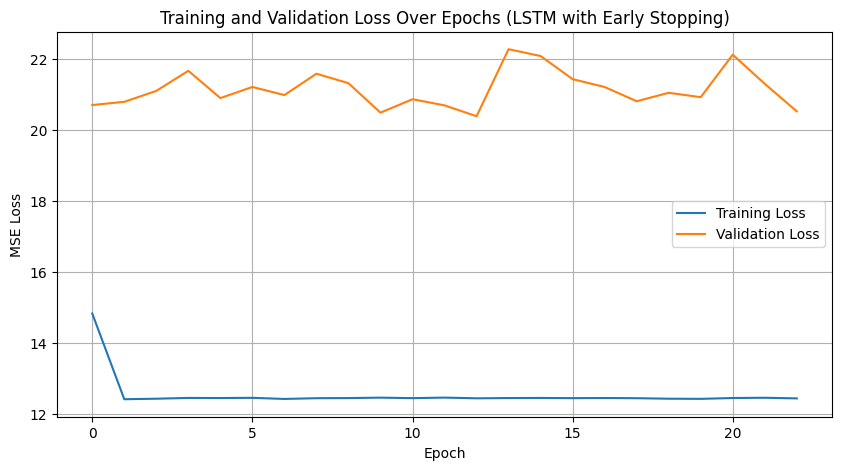


Loading best model from best_rul_model.pth for final evaluation...


/var/folders/tz/k1k21d6x7j1d90h0t6dqf5yc0000gn/T/ipykernel_69037/2712134166.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_SAVE_

RULPredictorLSTM(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [17]:

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title("Training and Validation Loss Over Epochs (LSTM with Early Stopping)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()

# --- 6. Load Best Model and Evaluate on Test Simulations ---
print(f"\nLoading best model from {MODEL_SAVE_PATH} for final evaluation...")
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
model.eval()  # Set model to evaluation mode after loading



In [18]:
print("\nStarting Evaluation on Test Simulations...")

all_test_predictions = []
all_test_true_ruls = []
all_test_window_end_times = []
BATCH_SIZE = 64

with torch.no_grad():
    for sim_idx_in_list, test_dataset in enumerate(test_datasets):
        test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

        print(f"  Evaluating Simulation ID: {test_sim_ids[sim_idx_in_list]} with {len(test_dataset)} windows...")

        for inputs, targets, window_end_times in test_dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)

            all_test_predictions.extend(outputs.squeeze().cpu().numpy())
            all_test_true_ruls.extend(targets.cpu().numpy())
            all_test_window_end_times.extend(window_end_times.cpu().numpy())

all_test_predictions = np.array(all_test_predictions)
all_test_true_ruls = np.array(all_test_true_ruls)
all_test_window_end_times = np.array(all_test_window_end_times)




Starting Evaluation on Test Simulations...
  Evaluating Simulation ID: 13 with 1629 windows...
  Evaluating Simulation ID: 14 with 1629 windows...


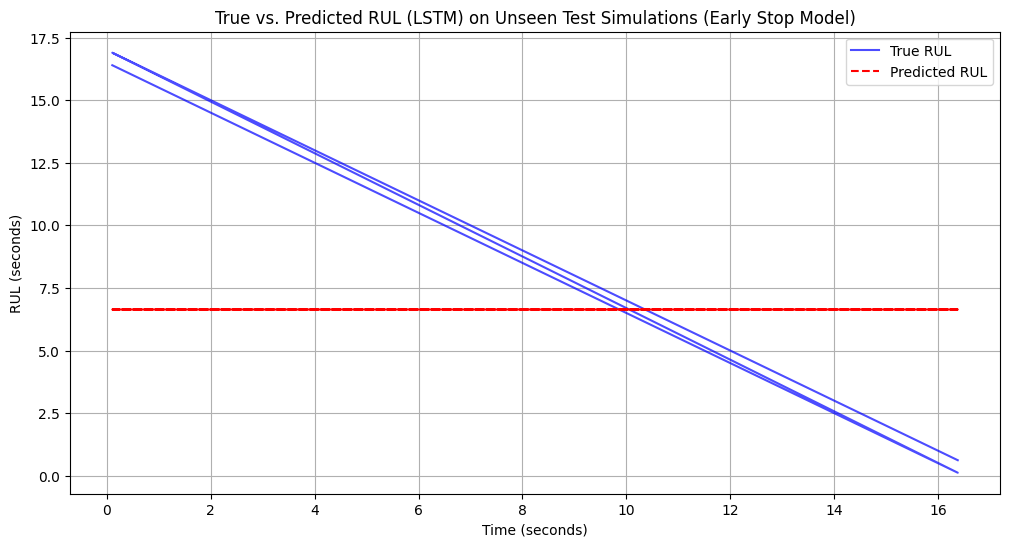


Overall Test Set Metrics (on 2 unseen simulations):
  MAE: 4.2907 seconds
  RMSE: 5.0664 seconds
  R-squared: -0.1575


In [19]:
# Plotting predictions vs true RUL for the test set
plt.figure(figsize=(12, 6))
plt.plot(all_test_window_end_times, all_test_true_ruls, label='True RUL', color='blue', alpha=0.7)
plt.plot(all_test_window_end_times, all_test_predictions, label='Predicted RUL', color='red', linestyle='--')
plt.title("True vs. Predicted RUL (LSTM) on Unseen Test Simulations (Early Stop Model)")
plt.xlabel("Time (seconds)")
plt.ylabel("RUL (seconds)")
plt.legend()
plt.grid(True)
plt.show()

# Calculate metrics for the entire test set
mae_test = mean_absolute_error(all_test_true_ruls, all_test_predictions)
rmse_test = np.sqrt(mean_squared_error(all_test_true_ruls, all_test_predictions))
r2_test = r2_score(all_test_true_ruls, all_test_predictions)

print(f"\nOverall Test Set Metrics (on {len(test_sim_ids)} unseen simulations):")
print(f"  MAE: {mae_test:.4f} seconds")
print(f"  RMSE: {rmse_test:.4f} seconds")
print(f"  R-squared: {r2_test:.4f}")